In [75]:
###### invite people for the Kaggle party
import numpy as np
import pandas as pd
import kaggle
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, StandardScaler
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [76]:
# Uploads the kaggleApi directly for easier use
from kaggle.api.kaggle_api_extended import KaggleApi

In [77]:
# Startup the api and authenticate it using my kaggle key (which was previously downloaded into my directory and put on the .gitignore list for security purposes)
api = KaggleApi()
api.authenticate()

In [78]:
# Downloads the dataset into our directory, Since it's multiple files it comes as a .zip file
api.competition_download_files('house-prices-advanced-regression-techniques')

In [80]:
import zipfile
with zipfile.ZipFile("house-prices-advanced-regression-techniques.zip","r") as zip_ref:
    zip_ref.extractall() # If I don't specify a directory it goes into the current directory

In [81]:
with open('data_description.txt','r') as file:
    file1=file.read()

In [82]:
# this is the info file where I have all the different explanations of the categories within the columns.  
# I should use this to double check if the values in the columns are within range
print(file1) 

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

In [83]:
# Import the train data
train = pd.read_csv('train.csv', )

In [84]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [85]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

**Alleys, FireplaceQu, PoolQC, Fence, MiscFeature are values with very high null rates**

In [86]:
YrSold=np.sort(train['YrSold'].unique())  # Looks like MoSold and YrSold are just integers but I think that's okay
YrSold

array([2006, 2007, 2008, 2009, 2010], dtype=int64)

In [87]:
np.sort(train['MoSold'].unique())  #Months seem to be within 1-12 so that's good

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

In [88]:
# This category has numbers but they are categorical in reality
np.sort(train['MSSubClass'].unique())

array([ 20,  30,  40,  45,  50,  60,  70,  75,  80,  85,  90, 120, 160,
       180, 190], dtype=int64)

In [89]:
# Lets change the building subclasses to an object so I can split it off later and make use dummy variables
train['MSSubClass']=train['MSSubClass'].astype('object')

In [90]:
MSSubClass=np.sort(train['MSSubClass'].unique())
MSSubClass

array([20, 30, 40, 45, 50, 60, 70, 75, 80, 85, 90, 120, 160, 180, 190],
      dtype=object)

In [91]:
uniqueness = {n:train[n].unique() for n in train.keys()} # This gives me all the unique values to compare to description.txt.

In [92]:
Missing = {n:train[n].isna() for n in train.keys()}

In [93]:
Missing_data=pd.DataFrame(Missing).sum()
# The missing data.
Missing_data[Missing_data>0]

LotFrontage     259
Alley          1369
MasVnrType        8
MasVnrArea        8
BsmtQual         37
               ... 
GarageQual       81
GarageCond       81
PoolQC         1453
Fence          1179
MiscFeature    1406
Length: 19, dtype: int64

In [94]:
# There are some areas with A LOT of missing data that need to be dropped.
# First off there is one dataset with not electrical data so that is easy to drop
train_clean = train.dropna(subset = ['Electrical'])

In [95]:
# MiscFeature I'm thinking of dropping because there is a category for MiscFeature Value 
# I'll test if there are any missmatching first
train_clean[train_clean['MiscFeature'].isna()]['MiscVal'].describe()

count    1405.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: MiscVal, dtype: float64

In [96]:
train_clean[train_clean['MiscVal']>0]['MiscFeature'].unique()
# Looks like there are no NaN for any features that have a monitary value

array(['Shed', 'Gar2', 'Othr', 'TenC'], dtype=object)

In [97]:
# Second there are some categories/columns that are missing a great deal of data.  Alley, Pool, Fence and MiscFeature.
# I'm going to drop Alley because I don't believe that it is a major feature in home buying.  MISC feature is too vague
# Pool I'm keeping even though it's very small because I know that this increases the price of a property
# Fence I'm also leaving in because a poor quality fence will drop the value of a home because it will have to be addressed by the new owners
train_clean = train.drop(['Alley', 'MiscFeature'], axis=1)

In [98]:
# It looks like some of the houses have NaN in the Masenry Veneer Type.  Looking at the category 'None' some of them have area and some don't  
# So I must descide if the ones with NaN are area 0 and type None or should I drop them
# So I have two questions.  Are the ones with 'None' and have an area the error or are the NaN values actually None type and 0 area?
train_clean[train_clean['MasVnrType']=='None']['MasVnrArea'].describe()

count    864.000000
mean       1.094907
std       18.569659
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max      344.000000
Name: MasVnrArea, dtype: float64

In [99]:
MasVnrType_None =train_clean[train_clean['MasVnrType']=='None']['MasVnrArea']

In [100]:
MasVnrType_None.describe()

count    864.000000
mean       1.094907
std       18.569659
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max      344.000000
Name: MasVnrArea, dtype: float64

In [101]:
# Well there are five of these.  Clearly 1 is not good data. Can't have one ft of masenry.  so those have to go.  I'm going to guess that the rest are probably mis classified as "None"
MasVnrType_None[MasVnrType_None>0]

624     288.0
773       1.0
1230      1.0
1300    344.0
1334    312.0
Name: MasVnrArea, dtype: float64

In [102]:
# For the data that has a Vaneer type there are still some that equal 0 feet.  That also seems like bad data.
train_clean[train_clean['MasVnrType']!='None']['MasVnrArea'].describe()

count     588.000000
mean      254.430272
std       205.620539
min         0.000000
25%       112.750000
50%       202.500000
75%       329.250000
max      1600.000000
Name: MasVnrArea, dtype: float64

In [103]:
MasVnrType_Some = train_clean[train_clean['MasVnrType']!='None']['MasVnrArea']

In [104]:
# Two entries that need to go
MasVnrType_Some[MasVnrType_Some==0]

688     0.0
1241    0.0
Name: MasVnrArea, dtype: float64

In [105]:
# Removes the Vaneered masenry that had area of zero
train_clean=train_clean.drop(train_clean[(train_clean['MasVnrType']!='None') & (train_clean['MasVnrArea'] == 0.0)].index)
train_clean[train_clean['MasVnrType']!='None']['MasVnrArea'].describe()

count     586.000000
mean      255.298635
std       205.431939
min        11.000000
25%       113.250000
50%       203.000000
75%       331.750000
max      1600.000000
Name: MasVnrArea, dtype: float64

In [106]:
# Removes the non-vaneered masenry that have area above zero
train_clean=train_clean.drop(train_clean[(train_clean['MasVnrType']=='None') & (train_clean['MasVnrArea'] > 0.0)].index)
train_clean[train_clean['MasVnrType']=='None']['MasVnrArea'].describe()

count    859.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: MasVnrArea, dtype: float64

In [107]:
train_clean['MasVnrType'].describe()

count     1445
unique       4
top       None
freq       859
Name: MasVnrType, dtype: object

In [108]:
train_clean['MasVnrArea'].fillna(0)

0       196.0
1         0.0
2       162.0
3         0.0
4       350.0
        ...  
1455      0.0
1456    119.0
1457      0.0
1458      0.0
1459      0.0
Name: MasVnrArea, Length: 1453, dtype: float64

In [109]:
# Setting the MasVnrType NaN to 'None'
train_clean['MasVnrType'].fillna(value = 'None', inplace=True)
train_clean['MasVnrType'].unique() # Checking if it worked

array(['BrkFace', 'None', 'Stone', 'BrkCmn'], dtype=object)

In [110]:
# Setting the corresponding NaN in MasVnrArea to 0
train_clean['MasVnrArea'].fillna(value = 0, inplace=True)
train_clean['MasVnrArea'].isna().sum() # Checking if it worked

0

In [111]:
# No duplicate Id's so that's a positive
train_clean.duplicated(subset=['Id']).sum()

0

<AxesSubplot:xlabel='MasVnrArea', ylabel='Count'>

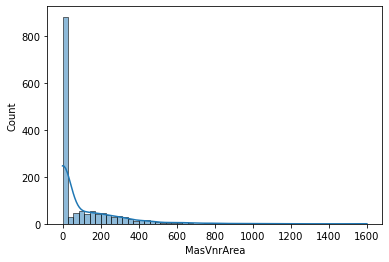

In [112]:
sns.histplot(data=train_clean, x="MasVnrArea", kde=True)

In [113]:
train_clean['MasVnrArea'].describe()

count    1453.000000
mean      102.962836
std       180.827856
min         0.000000
25%         0.000000
50%         0.000000
75%       164.000000
max      1600.000000
Name: MasVnrArea, dtype: float64

In [114]:
# Lets check what has NaN in our data
Missing=train_clean.isna().sum()
Missing

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      257
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 79, dtype: int64

In [115]:
Missing[Missing>0]

LotFrontage      257
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
                ... 
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1446
Fence           1172
Length: 15, dtype: int64

**how to group the data by neighborhood so we can add a new column that has mean_neighborhood price**

I need to do this first because after I split the data in to dummie categories we will have issues getting the data agoin

In [116]:
df = train_clean.copy()
df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodD

In [117]:
#makes a new db with the mean neighborhood prices
gf = df[['Neighborhood', 'YrSold', 'SalePrice']].groupby(['Neighborhood', 'YrSold']).mean()
# Problem #1  Each town doesn't have sales in every year from 2006-2010
pd.set_option('display.max_rows', None)
gf

SalePrice
Neighborhood YrSold               
Blmngtn      2006    217087.000000
             2007    183350.500000
             2008    175447.500000
             2009    176720.000000
             2010    192000.000000
Blueste      2008    151000.000000
             2009    124000.000000
BrDale       2006     96750.000000
             2007    113833.333333
             2008     95225.000000
             2009    116500.000000
             2010     88000.000000
BrkSide      2006    112746.666667
             2007    135737.500000
             2008    121707.142857
             2009    134994.117647
             2010     96500.000000
ClearCr      2006    199166.666667
             2007    236333.333333
             2008    208991.500000
             2009    169875.000000
             2010    246850.000000
CollgCr      2006    199016.406250
             2007    213999.933333
             2008    187718.055556
             2009    192317.769231
             2010    203700.000000
Crawfor      2006    196635.181818
             2007    198777.578947
             2008    254411.111111
             2009    180211.111111
             2010    296833.333333
Edwards      2006    134403.684211
             2007    132588.235294
             2008    132473.076923
             2009    123855.555556
             2010    111445.454545
Gilbert      2006    200250.625000
             2007    181967.947368
             2008    186000.000000
             2009    198636.842105
             2010    185500.000000
IDOTRR       2006     95758.714286
             2007    118933.333333
             2008     91642.857143
             2009     89580.000000
             2010     86278.166667
MeadowV      2006    123466.666667
             2007    105850.000000
             2008     98000.000000
             2009     88400.000000
             2010     81333.333333
Mitchel      2006    150036.363636
             2007    136731.818182
             2008    165280.000000
             2009    167860.461538
             2010    166950.000000
NAmes        2006    138985.454545
             2007    143509.615385
             2008    151553.160000
             2009    143880.000000
             2010    153665.909091
NPkVill      2007    141500.000000
             2008    140000.000000
             2009    146937.500000
             2010    136750.000000
NWAmes       2006    201482.352941
             2007    175267.083333
             2008    193820.000000
             2009    185133.333333
             2010    187428.571429
NoRidge      2006    322333.333333
             2007    399730.909091
             2008    304750.000000
             2009    323875.000000
             2010    289938.285714
NridgHt      2006    305491.882353
             2007    310833.111111
             2008    332422.833333
             2009    323143.500000
             2010    308281.125000
OldTown      2006    135963.807692
             2007    114794.625000
             2008    147670.000000
             2009    116378.291667
             2010    122464.285714
SWISU        2006    130125.000000
             2007    187500.000000
             2008    139612.500000
             2009    141048.000000
             2010    141333.333333
Sawyer       2006    149735.294118
             2007    130431.250000
             2008    128900.692308
             2009    136925.727273
             2010    132400.000000
SawyerW      2006    164787.500000
             2007    209300.000000
             2008    184080.000000
             2009    183934.133333
             2010    184076.923077
Somerst      2006    210268.875000
             2007    232593.304348
             2008    225631.000000
             2009    236315.000000
             2010    206762.500000
StoneBr      2006    365046.666667
             2007    251481.500000
             2008    245000.000000
             2009    319967.400000
             2010    318886.400000
Timber       2006    264485.714286
             2007    229470.545455


In [118]:
pd.set_option('display.max_rows', 10)

**At this point I realized that I don't have data for all the years.  Therefore I either have to eliminate any prediction that doesn't have that year, or I can try to fill the data with the mean between the first and last points.  This doesn't help if the data missing is from 2006**

In [119]:
# make a list of all the years in the dataset
years=np.array(df['YrSold'].unique())
years

array([2008, 2007, 2006, 2009, 2010], dtype=int64)

In [120]:
# make a list of all the Neiborhoods in the dataset
Neighborhoods =np.array(df['Neighborhood'].unique())
Neighborhoods

array(['CollgCr', 'Veenker', 'Crawfor', 'NoRidge', 'Mitchel', 'Somerst',
       'NWAmes', 'OldTown', 'BrkSide', 'Sawyer', 'NridgHt', 'NAmes',
       'SawyerW', 'IDOTRR', 'MeadowV', 'Edwards', 'Timber', 'Gilbert',
       'StoneBr', 'ClearCr', 'NPkVill', 'Blmngtn', 'BrDale', 'SWISU',
       'Blueste'], dtype=object)

In [121]:
# Turn these into a list
q=[]
for n in Neighborhoods:
    for y in years:
        q.append([n,y])

In [122]:
# Lable the columns
q=pd.DataFrame(q)
q.rename(columns={0:'Neighborhood',1:'YrSold'}, inplace=True)

In [123]:
q

,Neighborhood,YrSold
0,CollgCr,2008
1,CollgCr,2007
2,CollgCr,2006
3,CollgCr,2009
4,CollgCr,2010
...,...,...
120,Blueste,2008
121,Blueste,2007
122,Blueste,2006
123,Blueste,2009


In [124]:
pd.set_option('display.max_rows', None)
nf=pd.merge(gf,q,on=['Neighborhood','YrSold'],how='outer').sort_values(['Neighborhood','YrSold'])
nf.reset_index(inplace=True)
nf.drop('index',axis=1,inplace=True)
nf

,Neighborhood,YrSold,SalePrice
0,Blmngtn,2006,217087.000000
1,Blmngtn,2007,183350.500000
2,Blmngtn,2008,175447.500000
3,Blmngtn,2009,176720.000000
4,Blmngtn,2010,192000.000000
5,Blueste,2006,NaN
6,Blueste,2007,NaN
7,Blueste,2008,151000.000000
8,Blueste,2009,124000.000000
9,Blueste,2010,NaN


In [125]:
#Reset the max rows so I don't get overwhelmed
pd.set_option('display.max_rows', 10)

**Now I have all the Neighborhoods but not all of the means for each year I need to fill in the values**

In [126]:
# Liner Regression equations
# Y=mX+b where m=(n*sum(x*y)-(sum(x)*sum(y)))/(n*(sum(x**2))-sum(x)**2) and b=(sum(y)*sum(x**2)-sum(x)-sum(x*y))/(n(sum(x**2))-sum(x)**2)

# My values I calculate the LR with
X=nf[nf['Neighborhood']=='Veenker'] #Pick a neighborhood
Y=X[X['SalePrice'].isna()] # Separate the years w/o a SalePrice
X.dropna(inplace=True) # Drop all NaN's

# Make the equation
x=X['YrSold']
y=X['SalePrice']
n=len(X)

m=(n*np.sum(x*y)-(np.sum(x)*np.sum(y)))/(n*(np.sum(x**2))-np.sum(x)**2)
b=(np.sum(y)*np.sum(x**2)-np.sum(x)*np.sum(x*y))/(n*np.sum(x**2)-np.sum(x)**2)

In [127]:
for n in Y['YrSold']:
    print('Projected cost for', n,'is:', m*n+b)

Projected cost for 2009 is: 214744.4443359375
Projected cost for 2010 is: 200077.7776692696


In [128]:
print ('Slope=',m,'Intercept=',b)

Slope= -14666.666666666666 Intercept= 29680077.77766927


In [129]:
pred=[]
Yr=[2006,2007,2008,2009,2010]
for n in Yr:
    pred.append(m*n+b)
pred

[258744.4443359375,
 244077.7776692696,
 229411.1110026054,
 214744.4443359375,
 200077.7776692696]

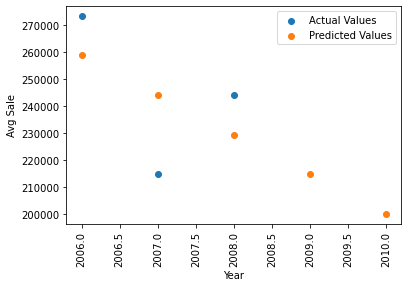

In [130]:
_1=plt.scatter(X['YrSold'],X['SalePrice'],label='Actual Values')
_2=plt.scatter(Yr,pred, label='Predicted Values')
_=plt.xticks(rotation=90)
_=plt.xlabel('Year')
_=plt.ylabel('Avg Sale')
_= plt.legend()
plt.show()

**This seems to work but I wasn't expecting the average price to be going down... Maybe linear isn't the best?**

In [131]:
# Let's automate this.  The goal is to calculate the linear regression for the datapoints in each neighborhood which doesn't have all the years.
# Then take that LR and calculate an approximate value for the mean sales of that year based on previous/following years.
# I'm not filling in the mean between the previous and following years because some of my data has nothing below or above it.
def linear_reg (Data,h='Neighborhood',ys='YrSold',sp='SalePrice'):
    """Calculate missing values using linear regression from the years and mean neighborhood price available. h=Neighborhood,ys=YrSold,sp=SalePrice"""
    Neighborhood=list(Data[h].unique())
    Data=Data
    result=[]

    for j in Neighborhood:
        X=Data[Data[h]==j]
        if X[sp].isna().sum()>0:
            Y=list(X[ys][pd.isna(X[sp])]) # Separate the years w/o a SalePrice
            X.dropna(inplace=True) # Drop all NaN's
            
            x=X[ys]
            y=X[sp]
            n=len(X)

            m=(n*np.sum(x*y)-(np.sum(x)*np.sum(y)))/(n*(np.sum(x**2))-np.sum(x)**2)
            b=(np.sum(y)*np.sum(x**2)-np.sum(x)*np.sum(x*y))/(n*np.sum(x**2)-np.sum(x)**2)
            for k in Y:
                result.append([j,k,k*m+b])
    return result

In [132]:
# This gives me the neighborhood, YrSold and projected neighborhood Mean.
Nbhd_proj_lr=pd.DataFrame(linear_reg(nf))
Nbhd_proj_lr.columns = ['Neighborhood', 'YrSold', 'SalePrice']
Nbhd_proj_lr

,Neighborhood,YrSold,SalePrice
0,Blueste,2006,205000.000000
1,Blueste,2007,178000.000000
2,Blueste,2010,97000.000000
3,NPkVill,2006,143125.000000
4,Veenker,2009,214744.444336
5,Veenker,2010,200077.777669


In [133]:
def Mean_Projection (Data,h='Neighborhood',ys='YrSold',sp='SalePrice'):
    """Calculate missing values using mean from the years and mean neighborhood price available. h=Neighborhood,ys=YrSold,sp=SalePrice"""
    Neighborhood=list(Data[h].unique())
    Data=Data
    result=[]

    for j in Neighborhood:
        X=Data[Data[h]==j]
        if X[sp].isna().sum()>0:
            Y=list(X[ys][pd.isna(X[sp])]) # Separate the years w/o a SalePrice
            X.dropna(inplace=True) # Drop all NaN's
            n=len(X)
            mean = sum(X[sp])/n
            for k in Y:
                result.append([j,k,mean])
    return result

In [134]:
Nbhd_proj_mean=pd.DataFrame(Mean_Projection(nf))
Nbhd_proj_mean.columns = ['Neighborhood', 'YrSold', 'SalePrice']
Nbhd_proj_mean

,Neighborhood,YrSold,SalePrice
0,Blueste,2006,137500.000000
1,Blueste,2007,137500.000000
2,Blueste,2010,137500.000000
3,NPkVill,2006,141296.875000
4,Veenker,2009,244077.777778
5,Veenker,2010,244077.777778


In [135]:
# merge the predicted means with the actual means
nf2=nf.dropna().merge(Nbhd_proj_lr,how='outer').sort_values(['Neighborhood','YrSold'])
nf2.reset_index(inplace=True)
nf2.drop('index',axis=1,inplace=True)
nf2.rename(columns={'SalePrice':'NeighborhoodPrice'}, inplace=True)
nf2

,Neighborhood,YrSold,NeighborhoodPrice
0,Blmngtn,2006,217087.000000
1,Blmngtn,2007,183350.500000
2,Blmngtn,2008,175447.500000
3,Blmngtn,2009,176720.000000
4,Blmngtn,2010,192000.000000
...,...,...,...
120,Veenker,2006,273333.333333
121,Veenker,2007,214900.000000
122,Veenker,2008,244000.000000
123,Veenker,2009,214744.444336


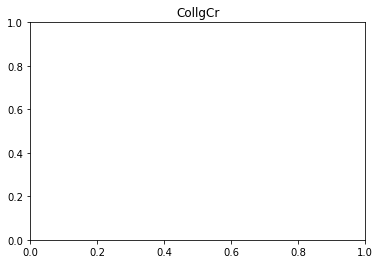

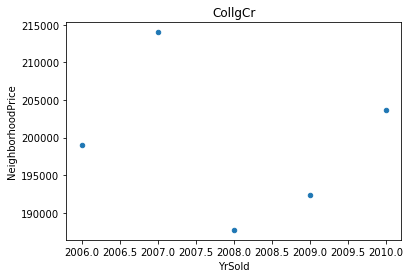

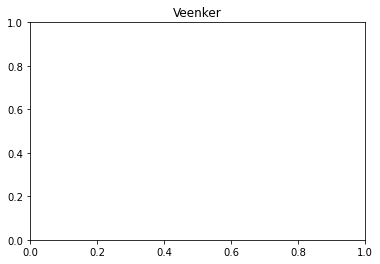

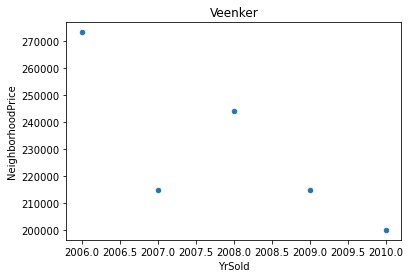

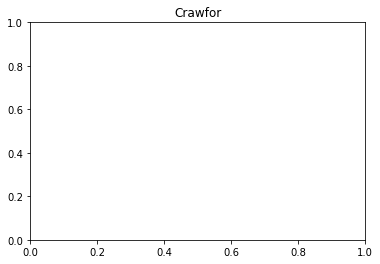

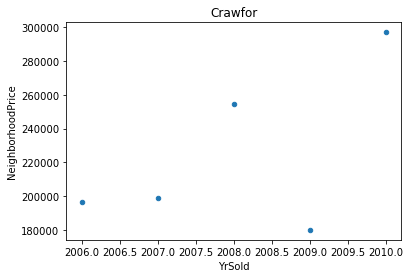

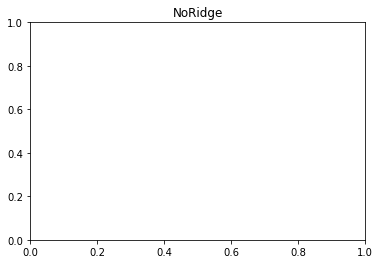

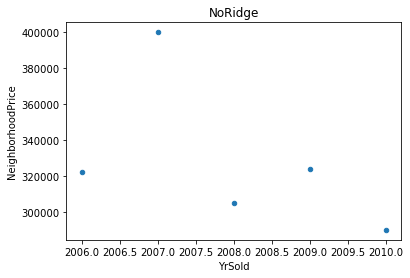

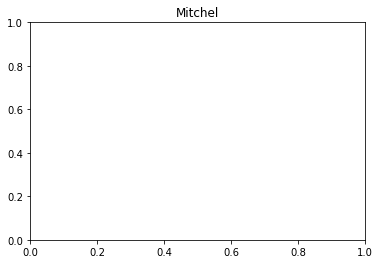

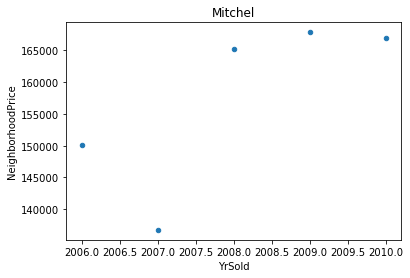

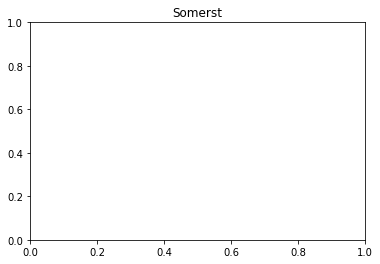

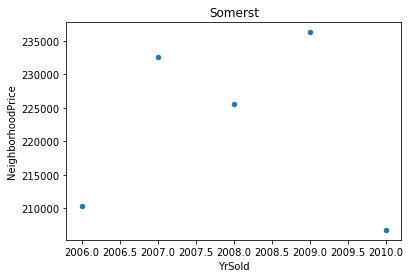

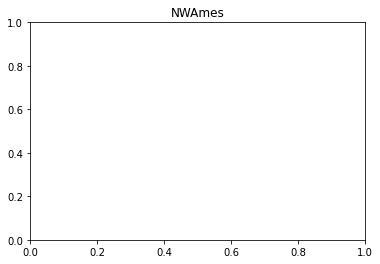

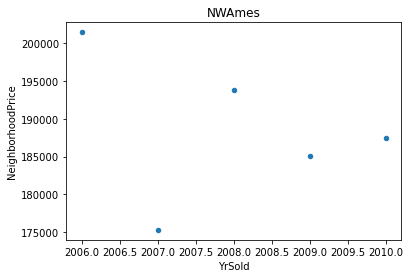

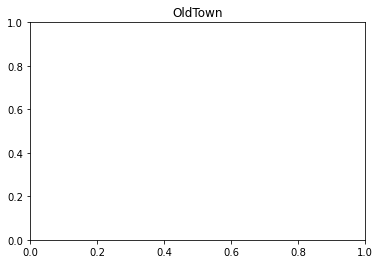

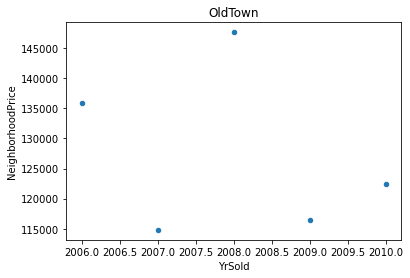

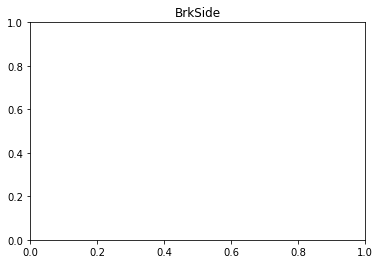

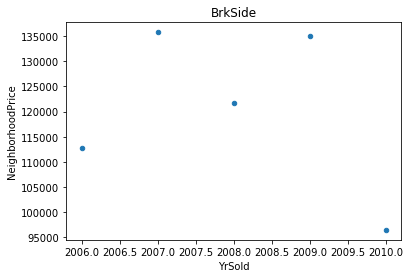

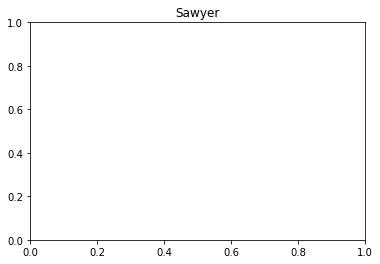

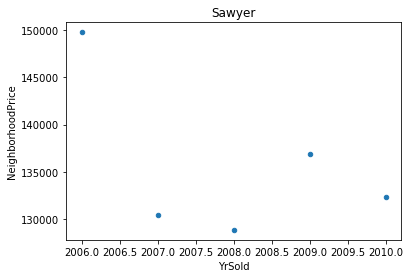

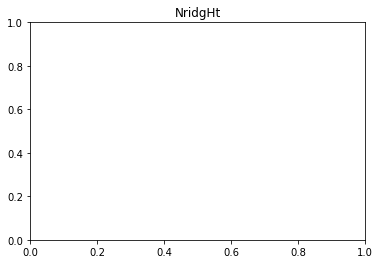

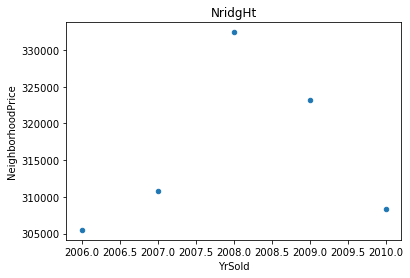

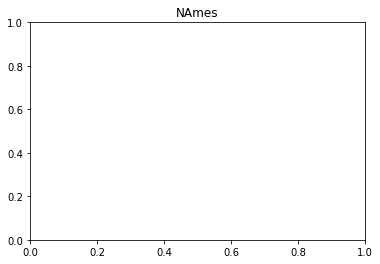

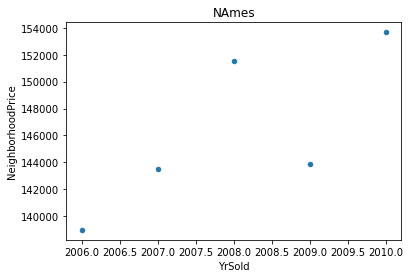

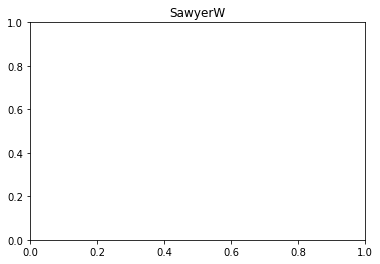

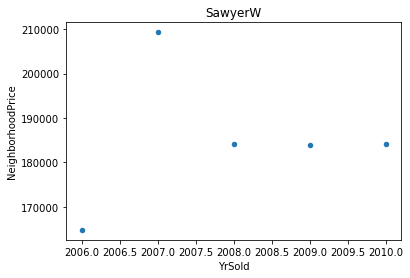

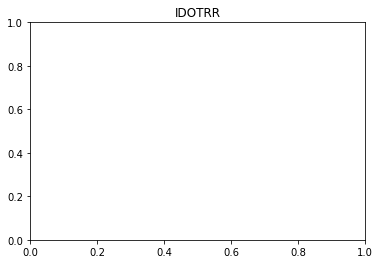

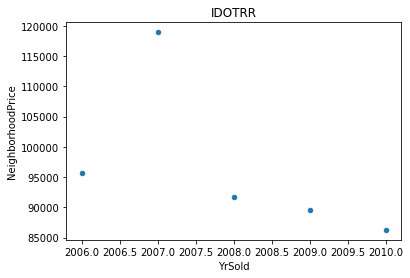

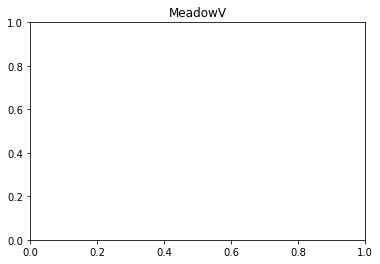

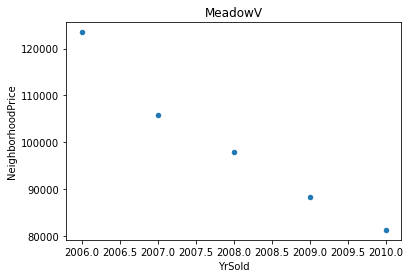

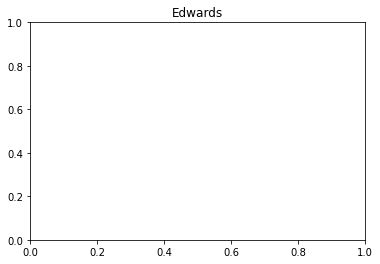

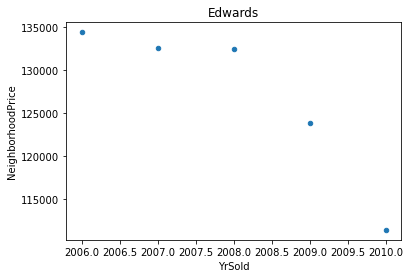

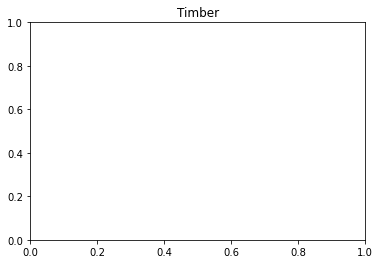

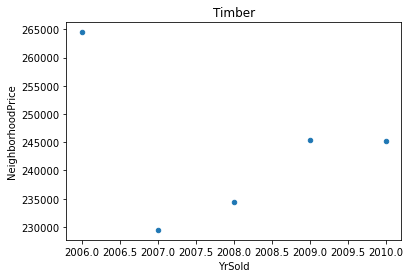

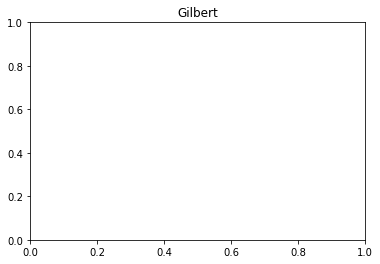

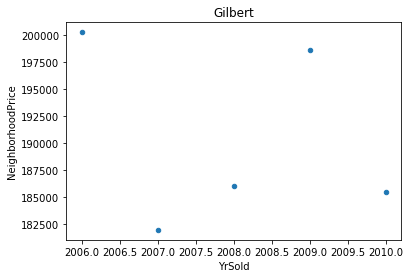

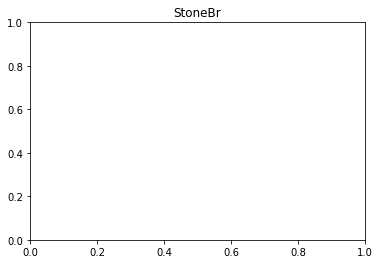

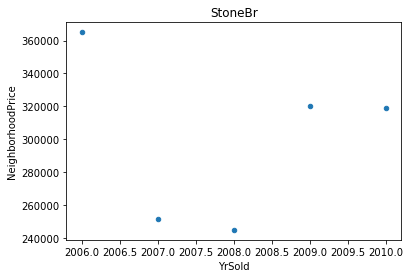

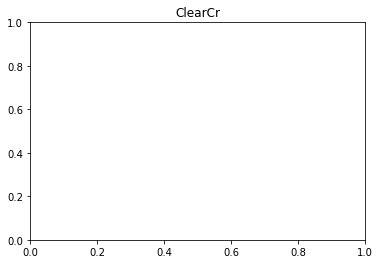

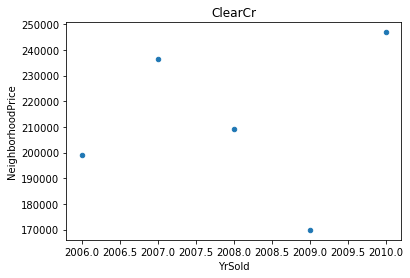

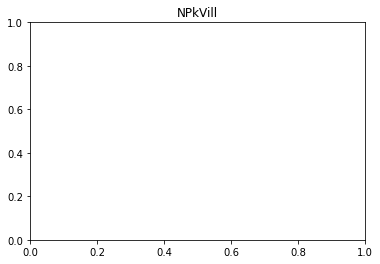

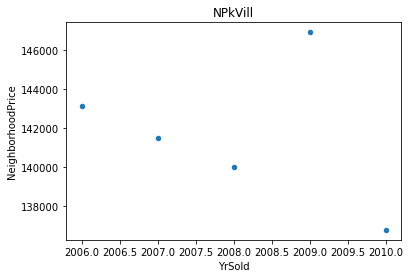

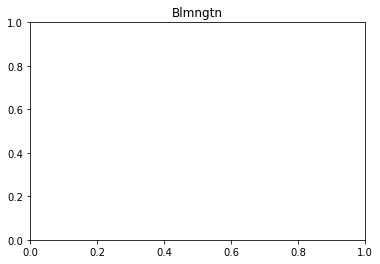

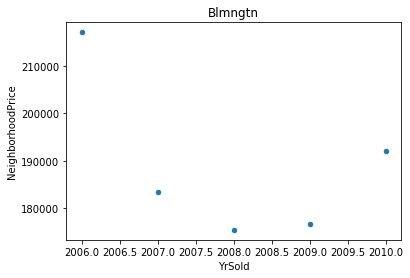

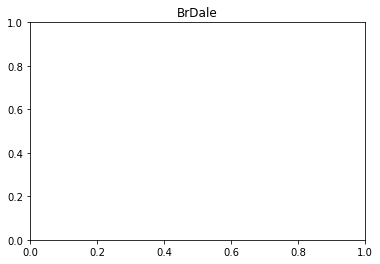

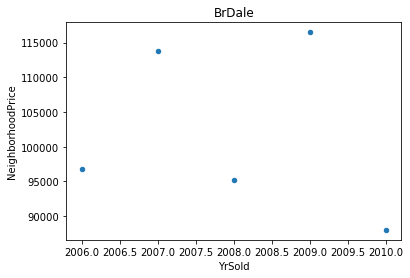

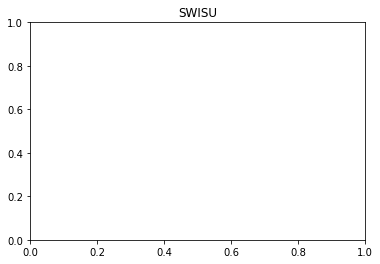

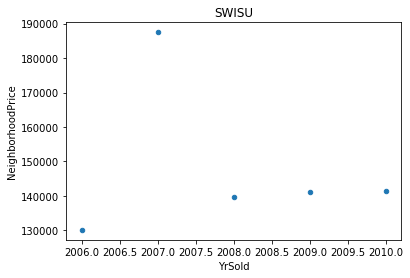

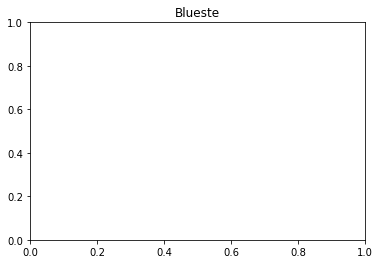

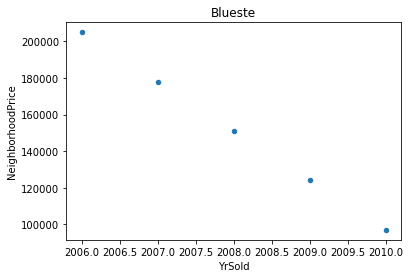

In [136]:
for n in Neighborhoods:
    fig, ax1 = plt.subplots(1, 1)
    #fig.set_size_inches(9, 5)
    ax1.set_title(n)
    ax1=nf2[nf2['Neighborhood']==n].plot('YrSold','NeighborhoodPrice', kind='scatter', title=n)
plt.show()

**Looking at all of these I'm thinking I should have used a polynomial to predict home prices instead of a linear equation?  I am going to look at what Mean does next**

In [137]:
# merge the predicted means with the actual means
nf3=nf.dropna().merge(Nbhd_proj_mean,how='outer').sort_values(['Neighborhood','YrSold'])
nf3.reset_index(inplace=True)
nf3.drop('index',axis=1,inplace=True)
nf3.rename(columns={'SalePrice':'NeighborhoodPrice'}, inplace=True)
nf3

,Neighborhood,YrSold,NeighborhoodPrice
0,Blmngtn,2006,217087.000000
1,Blmngtn,2007,183350.500000
2,Blmngtn,2008,175447.500000
3,Blmngtn,2009,176720.000000
4,Blmngtn,2010,192000.000000
...,...,...,...
120,Veenker,2006,273333.333333
121,Veenker,2007,214900.000000
122,Veenker,2008,244000.000000
123,Veenker,2009,244077.777778


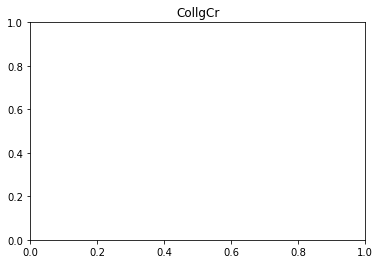

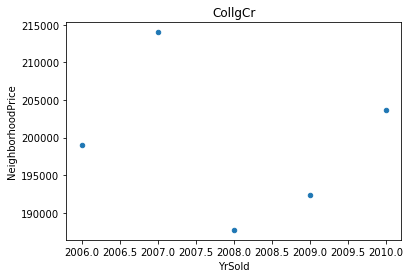

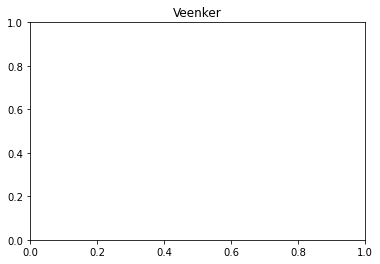

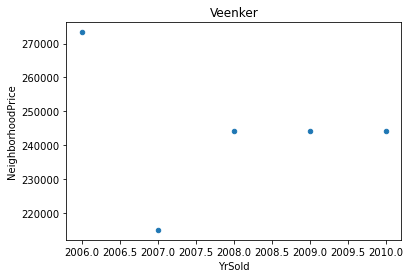

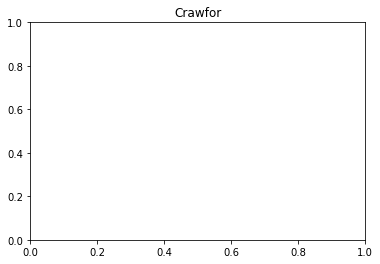

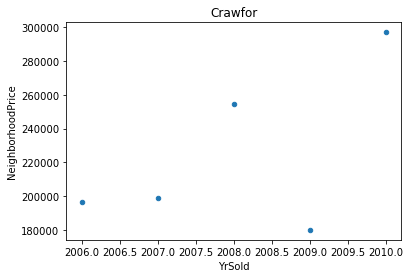

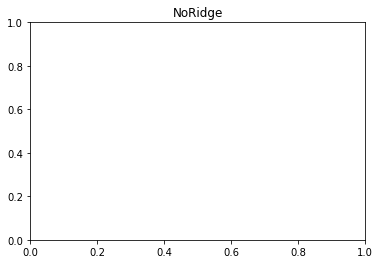

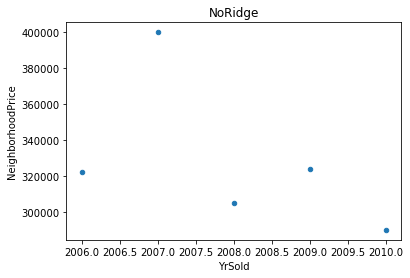

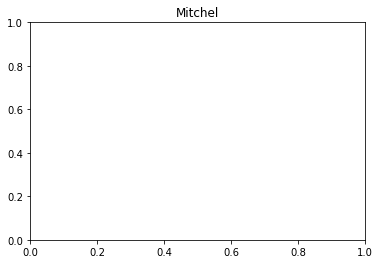

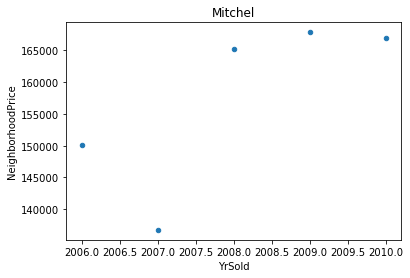

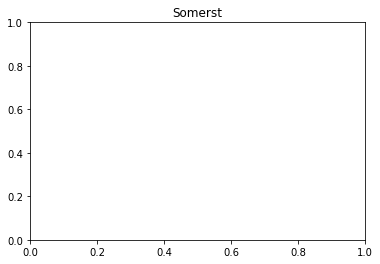

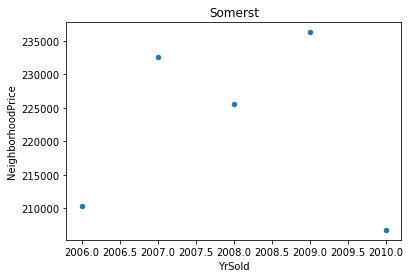

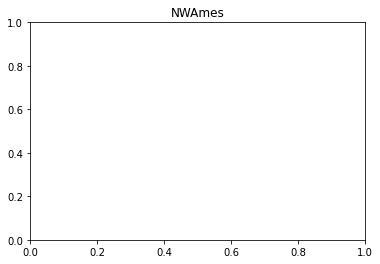

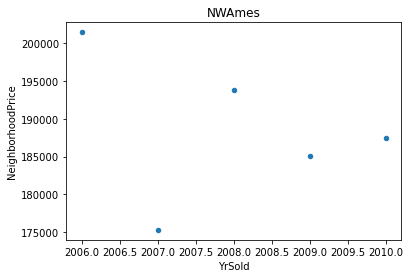

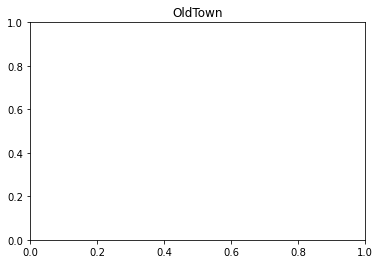

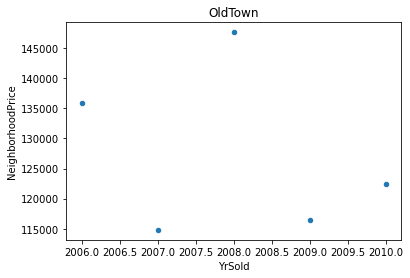

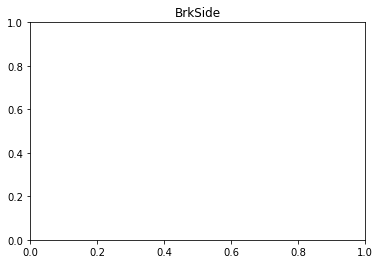

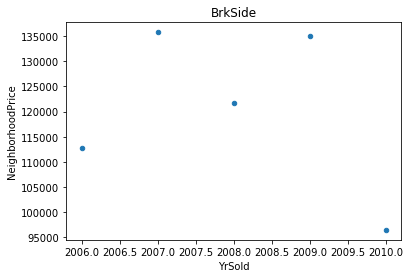

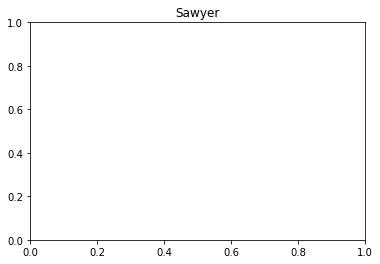

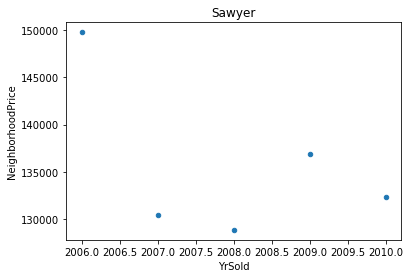

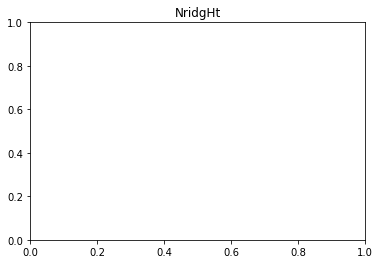

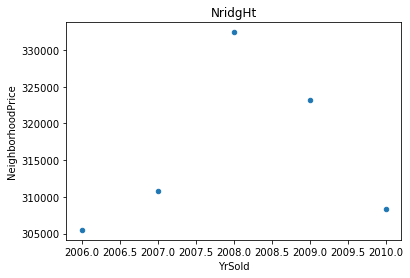

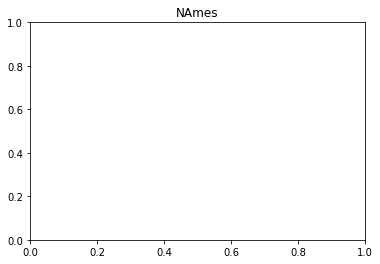

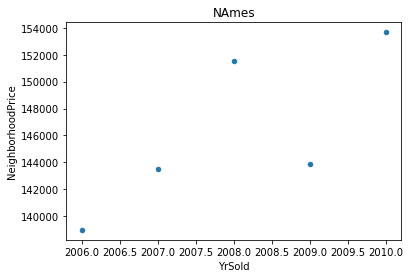

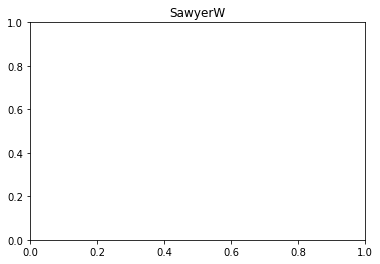

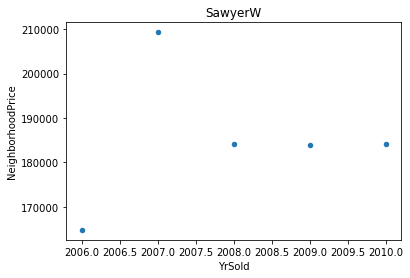

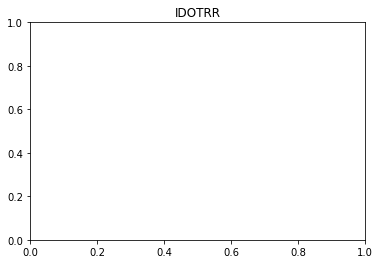

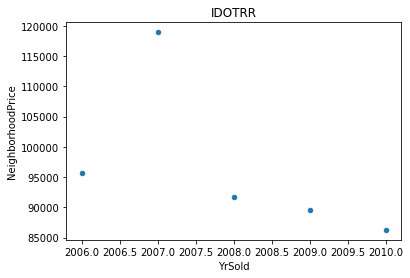

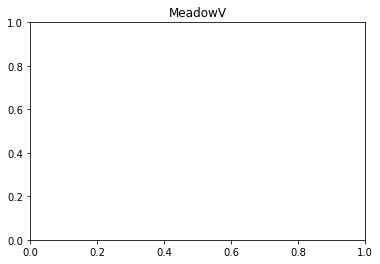

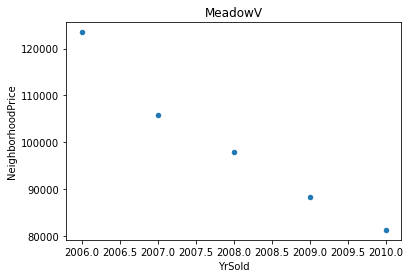

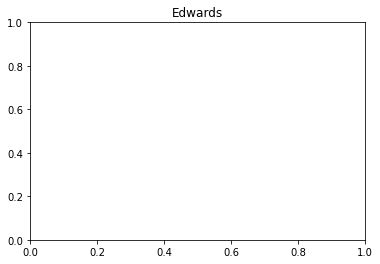

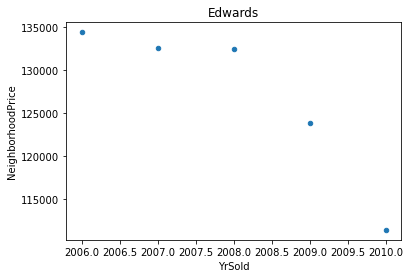

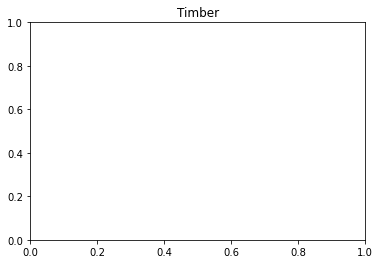

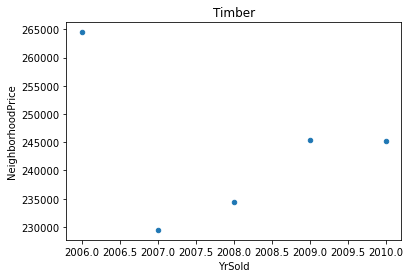

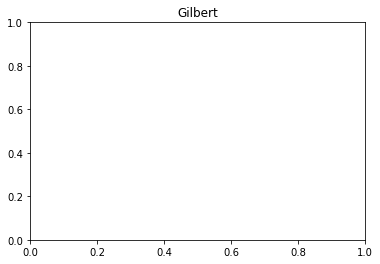

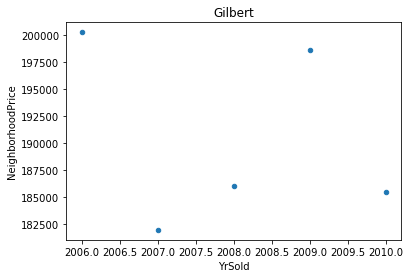

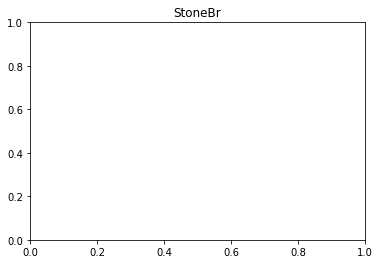

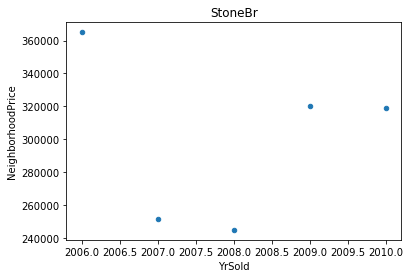

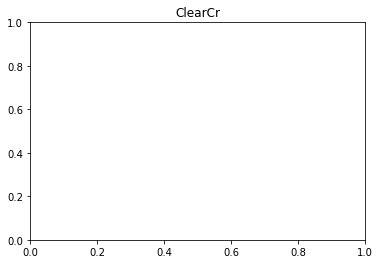

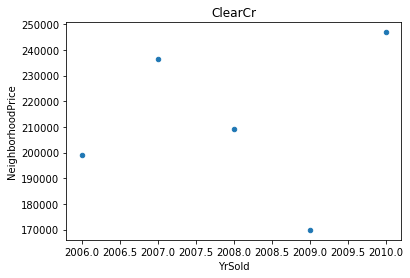

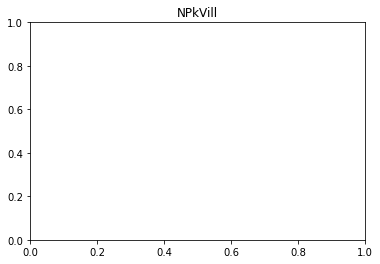

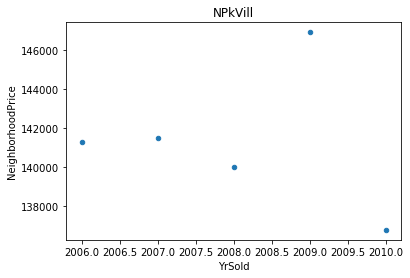

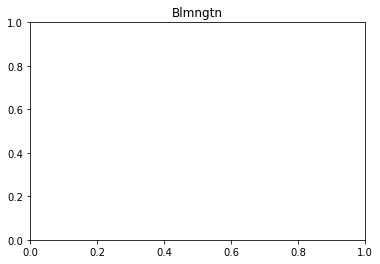

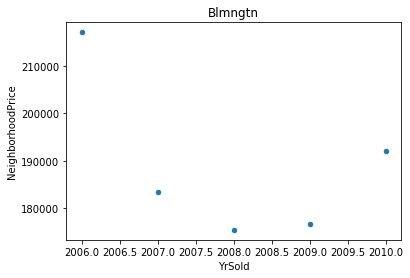

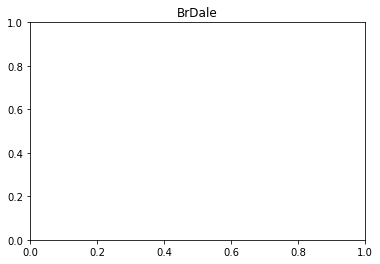

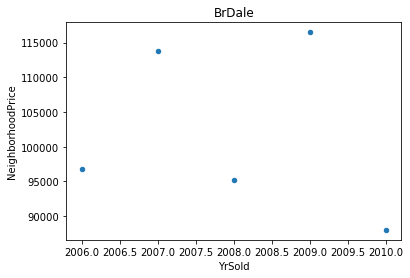

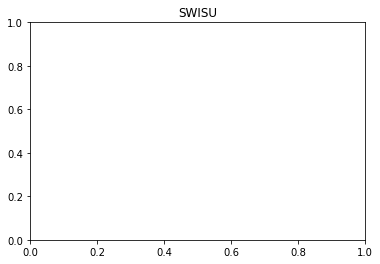

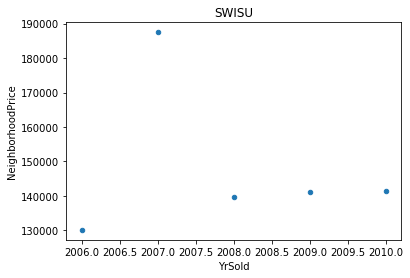

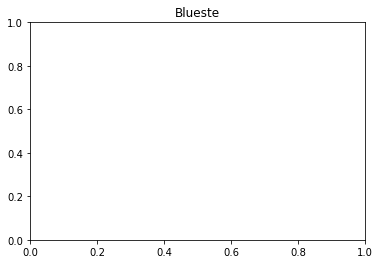

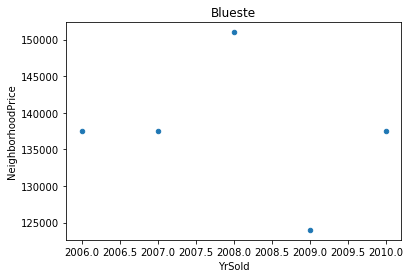

In [138]:
for n in Neighborhoods:
    fig, ax1 = plt.subplots(1, 1)
    #fig.set_size_inches(9, 5)
    ax1.set_title(n)
    ax1=nf3[nf3['Neighborhood']==n].plot('YrSold','NeighborhoodPrice', kind='scatter', title=n)
plt.show()

In [139]:
# Save as .csv so we can merge later with the test data
nf2.to_csv('Neighborhood_lr.csv', index=False)
nf3.to_csv('Neighborhood_Means.csv', index=False)

### Alternative method is to use rolling mean values

In [140]:
nf4=nf['SalePrice'].rolling(3, min_periods=1).mean()
nf4

0      217087.000000
1      200218.750000
2      191961.666667
3      178506.000000
4      181389.166667
           ...      
120    254643.611111
121    244464.444444
122    244077.777778
123    229450.000000
124    244000.000000
Name: SalePrice, Length: 125, dtype: float64

### So that didn't work... What if I use groupby?

In [141]:
pd.set_option('display.max_rows', None)
ff=nf[['Neighborhood', 'SalePrice']].groupby(['Neighborhood']).rolling(3, min_periods=1).mean()
ff.reset_index(inplace=True) #Redindex so I unstack the groupby so I can join the data
ff.drop('level_1', axis=1, inplace=True) # Drop the index created by groupby
ff.rename(columns={'SalePrice':'Rolling_Avg'}, inplace=True) # Rename the column so it's a new one
ff['YrSold']=nf['YrSold'] # Addin the dates so I can merge it with the neighborhood prediction data
#ff['Neighborhood_Price']=nf['SalePrice']
ff

,Neighborhood,Rolling_Avg,YrSold
0,Blmngtn,217087.000000,2006
1,Blmngtn,200218.750000,2007
2,Blmngtn,191961.666667,2008
3,Blmngtn,178506.000000,2009
4,Blmngtn,181389.166667,2010
5,Blueste,NaN,2006
6,Blueste,NaN,2007
7,Blueste,151000.000000,2008
8,Blueste,137500.000000,2009
9,Blueste,137500.000000,2010


### Well at the very least we don't get means that cross into the next neighborhood.
### Problem is this doesn't fill the NaN values

### So that didn't work... What if I use fillna?

In [142]:
pd.set_option('display.max_rows', None)
ff = nf[['Neighborhood', 'SalePrice']].groupby(['Neighborhood']).fillna(nf['SalePrice'].iloc[-3:].mean())
ff.reset_index(inplace=True) #Redindex so I unstack the groupby so I can join the data
ff.drop('index', axis=1, inplace=True) # Drop the index created by groupby
ff.rename(columns={'SalePrice':'Rolling_Avg'}, inplace=True) # Rename the column so it's a new one
ff['YrSold']=nf['YrSold'] # Addin the dates so I can merge it with the neighborhood prediction data
ff['Neighborhood_Price']=nf['SalePrice']
ff
# Why are all the filled values the same?
# Because I'm only taking the mean of the last 3 items in the SalePrice column

,Rolling_Avg,YrSold,Neighborhood_Price
0,217087.000000,2006,217087.000000
1,183350.500000,2007,183350.500000
2,175447.500000,2008,175447.500000
3,176720.000000,2009,176720.000000
4,192000.000000,2010,192000.000000
5,244000.000000,2006,NaN
6,244000.000000,2007,NaN
7,151000.000000,2008,151000.000000
8,124000.000000,2009,124000.000000
9,244000.000000,2010,NaN


### Moving on

In [143]:
# Merge the new dataframe gf which has the average sales price for that neighborhood that year
# I know that month of sales also has an impact but ther just isn't enough data for each month to enter that into account
# Going to use the predicted mean value instead of the rolling average for now as it seems to work better.
df=df.merge(nf2, left_on=['Neighborhood','YrSold'], right_on=['Neighborhood','YrSold'])

In [144]:
df.sample(12)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,NeighborhoodPrice
1413,1061,120,RL,41.0,4920,Pave,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,0,4,2010,WD,Normal,213500,318886.400000
1253,423,20,RL,100.0,21750,Pave,Reg,HLS,AllPub,Inside,...,0,NaN,NaN,0,2,2008,WD,Normal,113000,165280.000000
1248,505,160,RL,24.0,2308,Pave,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,0,6,2009,WD,Normal,147000,146937.500000
1221,696,20,RL,54.0,13811,Pave,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,0,7,2006,WD,Normal,176000,264485.714286
144,443,50,RM,52.0,6240,Pave,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,0,6,2008,WD,Normal,162900,121707.142857
1306,1058,60,RL,NaN,29959,Pave,IR2,Lvl,AllPub,FR2,...,0,NaN,NaN,0,1,2009,WD,Normal,248000,323875.000000
497,239,20,RL,93.0,12030,Pave,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,0,12,2007,New,Partial,318000,310833.111111
156,32,20,RL,NaN,8544,Pave,IR1,Lvl,AllPub,CulDSac,...,0,NaN,MnPrv,0,6,2008,WD,Normal,149350,128900.692308
606,495,30,RM,50.0,5784,Pave,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,0,12,2009,WD,Normal,91300,116378.291667
687,192,60,RL,NaN,7472,Pave,IR1,Lvl,AllPub,CulDSac,...,0,NaN,NaN,0,6,2007,WD,Normal,184000,143509.615385


In [145]:
#Neighborhood_Price is here but it will dissappear at some point... Why
df.NeighborhoodPrice.describe()

count      1453.000000
mean     180788.002753
std       60421.269596
min       81333.333333
25%      135963.807692
50%      167860.461538
75%      203700.000000
max      399730.909091
Name: NeighborhoodPrice, dtype: float64

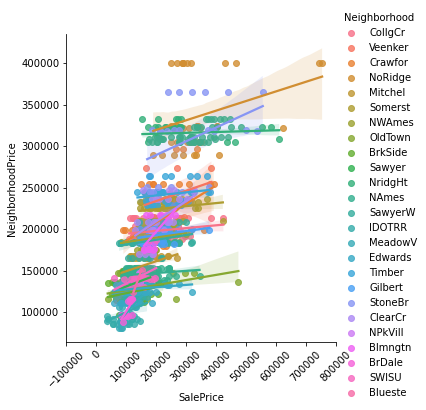

In [146]:
Plot_Neighberhood_Prices = sns.lmplot(x="SalePrice", y="NeighborhoodPrice", data=df, hue="Neighborhood")
loc, labels = plt.xticks()
Plot_Neighberhood_Prices.set_xticklabels(labels, rotation=45)

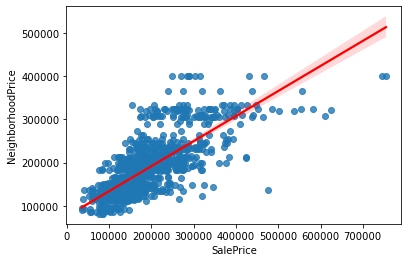

In [147]:
Plot_Prices_Regression = sns.regplot(x="SalePrice", y="NeighborhoodPrice", data=df,line_kws={"color": "red"});

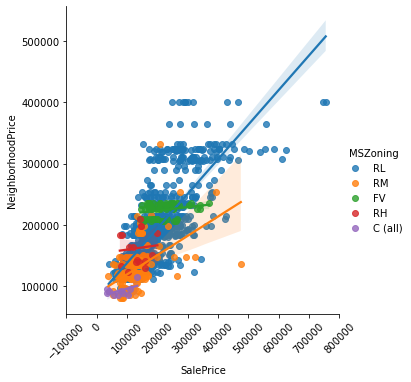

In [148]:
Plot_BuildType_Regression = sns.lmplot(x="SalePrice", y="NeighborhoodPrice", data=df, hue="MSZoning");
loc, labels = plt.xticks()
Plot_BuildType_Regression.set_xticklabels(labels, rotation=45)

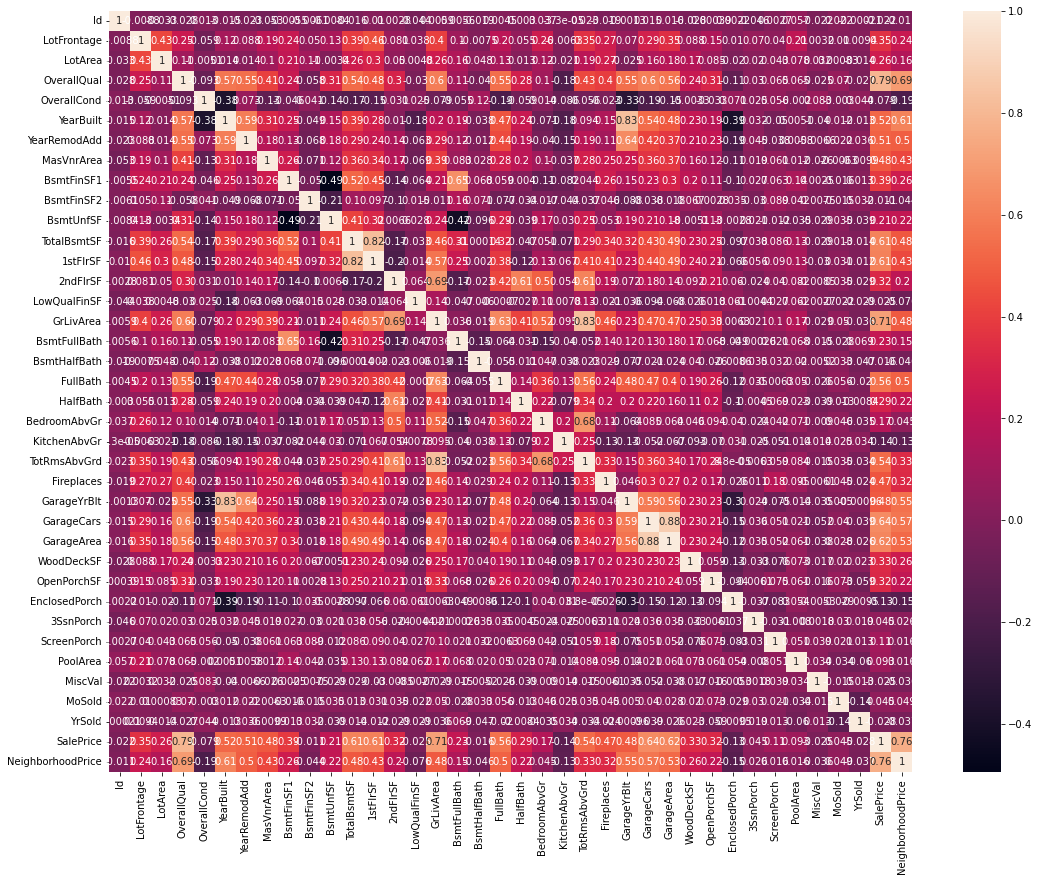

In [149]:
f, ax = plt.subplots(figsize=(18, 14))
ax = sns.heatmap(df.corr(), annot=True)

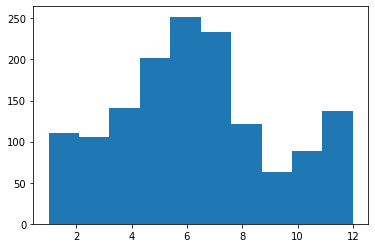

In [150]:
plt.hist(df['MoSold'])
plt.show()

In [151]:
# convert the month and year sold to a datetime object.  This could be helpful later on.  Maybe make this a new object?
df['DtSold']=pd.to_datetime(df.YrSold*10000+df.MoSold*100,format='%Y%m')

ValueError: unconverted data remains: 00

In [152]:
train_clean['FireplaceQu'].unique()

array([nan, 'TA', 'Gd', 'Fa', 'Ex', 'Po'], dtype=object)

In [153]:
train_clean['GarageFinish'].unique()

array(['RFn', 'Unf', 'Fin', nan], dtype=object)

Looks like the categories which have NA as one of their options has automatically been turned into a .NaN

So I have 43 categorical columns and what I need to do is to either turn all my categories into numbers or I need to try something else

In [154]:
# first I need to collect all my categorical categories 
cat_columns = train_clean.select_dtypes(['object']).columns

In [155]:
cat_columns

Index(['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
       'Fence', 'SaleType', 'SaleCondition'],
      dtype='object')

In [164]:
# Save the data before I make dummy and ordinal variables to try out in the machine learning algorythims 
train_clean.to_csv('train_clean.csv')
cat_col=pd.DataFrame(cat_columns)
cat_col.to_csv('cat_columns.csv')

In [ ]:
# one option is I can factorize these columns, but some of the data are 5-1 being good to poor and others are not so clear
# Is there a way to factorize the columns in reverse order?  I think for almost all of the data this would work.

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.factorize.html

In [ ]:
# Differentiate between ordinal and nonordinal data
# Ordinal is ranked theings like 1-10 or excelent-good-fair-poor
# Nonordinal is things like wood vs metal siding
# Rank the ordinal data
# setup dummies for the non ordinal by using pandas.get_dummies

https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html

In [ ]:
# Get the data by making unique dictionaries that have values associated with each unique value.
# So for each cat_column make a dictionary depending on the data type it is.

In [76]:
# Make a dictionary of each category and all the possible values in that category
cat_dict ={}
for n in list(cat_columns):
    cat_dict[n]=train_clean[n].unique()

In [77]:
cat_dict

{'MSSubClass': array([60, 20, 70, 50, 190, 45, 90, 120, 30, 85, 80, 160, 75, 180, 40],
       dtype=object),
 'MSZoning': array(['RL', 'RM', 'C (all)', 'FV', 'RH'], dtype=object),
 'Street': array(['Pave', 'Grvl'], dtype=object),
 'LotShape': array(['Reg', 'IR1', 'IR2', 'IR3'], dtype=object),
 'LandContour': array(['Lvl', 'Bnk', 'Low', 'HLS'], dtype=object),
 'Utilities': array(['AllPub', 'NoSeWa'], dtype=object),
 'LotConfig': array(['Inside', 'FR2', 'Corner', 'CulDSac', 'FR3'], dtype=object),
 'LandSlope': array(['Gtl', 'Mod', 'Sev'], dtype=object),
 'Neighborhood': array(['CollgCr', 'Veenker', 'Crawfor', 'NoRidge', 'Mitchel', 'Somerst',
        'NWAmes', 'OldTown', 'BrkSide', 'Sawyer', 'NridgHt', 'NAmes',
        'SawyerW', 'IDOTRR', 'MeadowV', 'Edwards', 'Timber', 'Gilbert',
        'StoneBr', 'ClearCr', 'NPkVill', 'Blmngtn', 'BrDale', 'SWISU',
        'Blueste'], dtype=object),
 'Condition1': array(['Norm', 'Feedr', 'PosN', 'Artery', 'RRAe', 'RRNn', 'RRAn', 'PosA',
        'RRNe']

In [78]:
# There are a lot of ratings with Ex, Gd, TA, Fa, Po, and NA.  Lets make a dictionary which translates these values into numerical values
# There is also a similar rating Gd, Av, Mn, No, NA that has been added as alternatives to values 1-3
rating ={'Ex': 5, 'Gd': 4, 'TA':3, 'Av':3, 'Fa':2, 'Mn':2, 'Po':1, 'No':1}

In [79]:
# Makes binary for Yes, No, and also has 1/2 for Partial
binary ={'Y':1, 'P': 0.5,'N':0}

In [80]:
# Converts Paved vs Gravel to be binary 1/0 leaving the NaN alone until we do some exploration to see if we need to drop the row
pave={'Pave':1,'Grvl':0}

In [98]:
rating_dic=[]
binary_dic=[]
pave_dic=[]
other_dic=[]

for n, m in cat_dict.items():
    if 'Ex' in m:
        rating_dic.append(n)
    elif 'Y' in m:
        binary_dic.append(n)
    elif 'Pave' in m:
        pave_dic.append(n)
    else:
        other_dic.append(n)

In [81]:
# changes values into an ordinal numbering scheme (and is scaleable)
# This is good for rating, binary and pave categories
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
cat_dict1=cat_dict.copy()
le.fit(cat_dict1)
df_le=le.transform(df)
# issue with this code is that the lables need to be in order, and my .unique() method of finding what the categories are doesn't always get them in order or have all the possible values.
# So I'm going to stick with my ratings code which isn't scalable for the moment

ValueError: y should be a 1d array, got an array of shape () instead.

In [103]:
le.fit(cat_dict['MSSubClass'])
test=le.transform(cat_dict['MSSubClass'])
test

array([ 5,  0,  6,  4, 14,  3, 10, 11,  1,  9,  8, 12,  7, 13,  2])

One of the issues with this approach is I may eventually need to decode what has been encoded.

In [82]:
# Make coppies to test our my data cleaning
cat_dict2=cat_dict.copy()
train_clean2=train_clean.copy()

In [83]:
# Lets see what is missing
Missing2=train_clean2.isna().sum()
Missing2[Missing2>0]

LotFrontage      257
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
                ... 
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1446
Fence           1172
Length: 15, dtype: int64

In [ ]:
# Then I have to map the values back onto the main dataset
for n,m in df.select_dtypes(['object']).items():
    if n in rating_dic:
        df[n] = list((pd.Series(m)).map(rating)) # This works just fine
    elif n in binary_dic:
        df[n] = list((pd.Series(m)).map(binary))    # So does this
    elif n in pave_dic:
        df[n] = list((pd.Series(m)).map(pave))  # This three

In [84]:
# Lets make a defn that will do this for me so I can use it when I need to clean my test data
def categorize (data):
    ''' Takes in the ordinal data from the home data and turns it into numeric data'''
    
    ## First I need to setup some variables to convert the ordinal data into which reflects the order or importance ###
    
    # There are a lot of ratings with Ex, Gd, TA, Fa, Po, and NA.  Lets make a dictionary which translates these values into numerical values
    # There is also a similar rating Gd, Av, Mn, No, NA that has been added as alternatives to values 1-3
    rating ={'Ex': 5, 'Gd': 4, 'TA':3, 'Av':3, 'Fa':2, 'Mn':2, 'Po':1, 'No':1}
    # Makes binary for Yes, No, and also has 1/2 for Partial
    binary ={'Y':1, 'P': 0.5,'N':0}
    # Converts Paved vs Gravel to be binary 1/0 leaving the NaN alone until we do some exploration to see if we need to drop the row
    pave={'Pave':1,'Grvl':0}
    
    # then a for loop to map the data in each of the categories to the appropriate ordinal number
    for n,m in data.select_dtypes(['object']).items():
        if n in rating_dic:
            data[n] = list((pd.Series(m)).map(rating)) # This works just fine
        elif n in binary_dic:
            data[n] = list((pd.Series(m)).map(binary))    # So does this
        elif n in pave_dic:
            data[n] = list((pd.Series(m)).map(pave))  # This three
#        elif n in other_dic:
#            le.transform(data[n])

In [85]:
categorize(train_clean2)

NameError: name 'rating_dic' is not defined

In [134]:
train_clean2

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,1,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,1,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,1,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,1,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,1,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,1,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,1,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,1,Reg,Lvl,AllPub,Inside,...,0,0,NaN,GdPrv,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,1,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,0,4,2010,WD,Normal,142125


In [135]:
train_clean2.select_dtypes(['object']).columns

Index(['MSSubClass', 'MSZoning', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'Foundation', 'BsmtFinType1',
       'BsmtFinType2', 'Heating', 'Electrical', 'Functional', 'GarageType',
       'GarageFinish', 'Fence', 'SaleType', 'SaleCondition'],
      dtype='object')

In [137]:
df1 = pd.get_dummies(data=train_clean2, columns=train_clean2.select_dtypes(['object']).columns)

In [138]:
df1.head()

,Id,LotFrontage,LotArea,Street,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,65.0,8450,1,7,5,2003,2003,196.0,4,...,0,0,0,1,0,0,0,0,1,0
1,2,80.0,9600,1,6,8,1976,1976,0.0,3,...,0,0,0,1,0,0,0,0,1,0
2,3,68.0,11250,1,7,5,2001,2002,162.0,4,...,0,0,0,1,0,0,0,0,1,0
3,4,60.0,9550,1,7,5,1915,1970,0.0,3,...,0,0,0,1,1,0,0,0,0,0
4,5,84.0,14260,1,8,5,2000,2000,350.0,4,...,0,0,0,1,0,0,0,0,1,0


In [140]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1453 entries, 0 to 1459
Columns: 256 entries, Id to SaleCondition_Partial
dtypes: float64(12), int64(39), uint8(205)
memory usage: 913.5 KB


In [141]:
df1.describe()

,Id,LotFrontage,LotArea,Street,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
count,1453.000000,1196.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,...,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000,1453.000000
mean,729.066070,70.077759,10518.968341,0.995871,6.099105,5.576050,1971.205093,1984.868548,102.962836,3.395733,...,0.003441,0.082588,0.002065,0.869236,0.069511,0.002753,0.008259,0.013765,0.821060,0.084652
std,421.629227,24.292668,10000.370314,0.064150,1.384121,1.114902,30.235336,20.655976,180.827856,0.574632,...,0.058581,0.275353,0.045408,0.337258,0.254409,0.052414,0.090533,0.116553,0.383434,0.278460
min,1.000000,21.000000,1300.000000,0.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,364.000000,59.000000,7540.000000,1.000000,5.000000,5.000000,1954.000000,1967.000000,0.000000,3.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,729.000000,69.000000,9473.000000,1.000000,6.000000,5.000000,1973.000000,1994.000000,0.000000,3.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1093.000000,80.000000,11606.000000,1.000000,7.000000,6.000000,2000.000000,2004.000000,164.000000,4.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1460.000000,313.000000,215245.000000,1.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [145]:
# I wonder if Id is redundant?  I could reset index to Id
df1=df1.reindex(df['Id'])
df1=df1.drop(['Id'], axis=1)

In [146]:
df1.head()

,LotFrontage,LotArea,Street,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,80.0,9600.0,1.0,6.0,8.0,1976.0,1976.0,0.0,3.0,3.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,60.0,9550.0,1.0,7.0,5.0,1915.0,1970.0,0.0,3.0,3.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
23,44.0,4224.0,1.0,5.0,7.0,1976.0,1976.0,0.0,3.0,3.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
33,70.0,10552.0,1.0,5.0,5.0,1959.0,1959.0,0.0,3.0,3.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
44,70.0,7945.0,1.0,5.0,6.0,1959.0,1959.0,0.0,3.0,3.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [120]:
# Making a Scaler object
scaler = StandardScaler()
# Fitting data to the scaler object
scaled_df = scaler.fit_transform(df1)
scaled_df = pd.DataFrame(scaled_df, columns=df.columns) 

In [121]:
scaled_df.head()

,LotFrontage,LotArea,Street,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,-0.083516,0.072464,0.064572,0.650809,-0.518960,0.989097,0.831325,0.326524,1.053766,-0.239416,...,-0.058926,-0.299572,-0.045612,0.387915,-0.274133,-0.052686,-0.09151,-0.11847,0.467313,-0.303669
1,0.616945,0.052407,0.064572,1.372543,-0.518960,1.187502,1.073360,-0.567977,1.053766,-0.239416,...,-0.058926,-0.299572,-0.045612,0.387915,-0.274133,-0.052686,-0.09151,-0.11847,0.467313,-0.303669
2,0.081298,-0.329071,0.064572,0.650809,-0.518960,1.055232,0.879732,-0.567977,1.053766,-0.239416,...,-0.058926,-0.299572,-0.045612,0.387915,-0.274133,-0.052686,-0.09151,-0.11847,0.467313,-0.303669
3,-0.083516,-0.134191,0.064572,0.650809,-0.518960,0.922962,0.686105,0.304437,1.053766,-0.239416,...,-0.058926,-0.299572,-0.045612,0.387915,3.647867,-0.052686,-0.09151,-0.11847,-2.139895,-0.303669
4,0.410927,0.245491,0.064572,-0.792659,0.376975,0.195476,-0.378847,1.966442,-0.686453,-0.239416,...,-0.058926,-0.299572,-0.045612,0.387915,-0.274133,-0.052686,-0.09151,-0.11847,0.467313,-0.303669


# Data Cleaning and orginization complete?

In [122]:
# Save the file
df1.to_csv('test_clean.csv')
scaled_df.to_csv('scaled_test_clean.csv')
gf.to_csv('Neighborhood_price.csv')

In [123]:
Plot_Neighberhood_Prices.savefig('Price_By_Hood.png')
Plot_Prices_Regression.figure.savefig('Price_Regression.png')
#Plot_BuildType_Regression.figure.savefig('Build_Type_Regression.png')

In [124]:
f.savefig('heatmap.png')